# Signals Analysis

In [ ]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import matplotlib_venn
import networkx as nx
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
sns.set_context('notebook')

In [ ]:
workingDirectory = '/home/jtao/analysis/signals_analysis/'
os.chdir(workingDirectory)

## Functions

In [ ]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''
    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0, 0, 0, 0]}
    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array)
        sequence_array_list.append(seq_array)
    return sequence_array_list




In [ ]:
def read_fasta(file_path):
    '''
    reads in a fasta file and returns a list of sequence ids and a list of sequences
    inputs: filepath - path to a fasta file
    outputs: sequence_list - a list of sequences
             id_list - a list of ids
    '''
    with open(file_path) as f:
        data = f.readlines()
    id_list = []
    sequence_list = []
    # loop through each sequence
    for line in data:
        if '>' in line:
            seq_id = line.strip()[1:]
            id_list.append(seq_id)
        else:
            seq = line.strip()
            sequence_list.append(seq)
    return sequence_list, id_list



In [ ]:
def read_motif_file(motifPath, pseudocount):
    '''
    reads all motif files in a directory 
    inputs: path to a directory containing homer motif files
    outputs: an array of tuples representing each motif
    '''
    name_metadata_dict = {}
    with open(motifPath) as f:
        data = f.readlines()
    name = '.'.join(motifPath.split('/')[-1].split('.')[:-1])
    matrix = []
    metadata = data[0].strip()
    for line in data[1:]:
        tokens = line.strip().split("\t")
        if len(tokens) > 1:
            scores = np.array([float(x) for x in tokens])
            scores = scores + pseudocount
            scores= scores/np.sum(scores)
            matrix.append(scores)
    return (name,np.array(matrix))

In [ ]:
def plot_motif_sequence(seq_index,
                        sequence_array_list, 
                        motif_score_dict, 
                        motif_score_rc_dict, 
                        motif_size_dict,
                        threshold = 0,
                        color_dict = None,
                        symmetric_motifs = [],
                        algorithm_plot = False,
                       ):
    '''
    visualize a single sequence using the highest scoring nonoverlapping motifs
    '''
    motif_names = sorted(motif_score_dict.keys())
    seq_array = sequence_array_list[seq_index]
    seq_size = seq_array.shape[0]
    # initialize position_node array
    position_node_array = [[] for x in range(seq_size)]

    # intialize graph
    seq_graph = nx.Graph()

    # initialize
    for motif in motif_names:
        motif_size = motif_size_dict[motif]
        indices = list(range(len(motif_score_dict[motif][seq_index])))
        forward_scores = motif_score_dict[motif][seq_index]
        revcomp_scores = motif_score_rc_dict[motif][seq_index]

        # identify motif instances using score threshold
        filtered_forward_motif_instances = [x for x in zip(indices, forward_scores) if x[1]>threshold]
        filtered_revcomp_motif_instances = [x for x in zip(indices, revcomp_scores) if x[1]>threshold]

        # create graph node for every forward motif instance
        for mi in filtered_forward_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='+')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

        # create graph node for every revcomp motif instance
        for mi in filtered_revcomp_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='-')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

    # figure out which edges to create
    edges_to_add = set()
    for pos in range(len(position_node_array)):
        nodes_at_pos = position_node_array[pos]
        # make sure edges are ordered alphabetically
        # so I don't have to deal with A-B and B-A
        nodes_at_pos.sort() 
        # generate proposed edges
        num_nodes = len(nodes_at_pos)
        for i in range(num_nodes - 1):
            for j in range(i+1, num_nodes):
                id_1 = nodes_at_pos[i]
                id_2 = nodes_at_pos[j]
                edges_to_add.add((id_1,id_2))
    seq_graph.add_edges_from(edges_to_add)

    # find best motif instances

    # loop through nodes and remove motif instances until there are no neighboring motif instances
    num_edges = seq_graph.number_of_edges()
    num_nodes = seq_graph.number_of_nodes()
    
    node_counts = [num_nodes]
    edge_counts = [num_edges]
    motif_instances =[]
    while num_edges > 0:
        # sort nodes by motif score
        sorted_nodes = sorted(seq_graph.nodes(data=True), key=lambda x: x[1]['score'], reverse=True)

        top_node = sorted_nodes[0]
        top_node_id = top_node[0]

        # save motif instance
        motif_instances.append(top_node)

        # remove node and neighbors from graph
        neighbors = seq_graph.neighbors(top_node_id)

        seq_graph.remove_node(top_node_id)
        seq_graph.remove_nodes_from(neighbors)

        num_edges = seq_graph.number_of_edges()
        num_nodes = seq_graph.number_of_nodes()

        node_counts.append(num_nodes)
        edge_counts.append(num_edges)
        
#         print(num_edges, num_nodes)
        
    # create list representation of motifs
    sorted_motif_instances = sorted(motif_instances, key = lambda x:x[1]['start'])
   
    if algorithm_plot:
        with sns.axes_style('ticks'):
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()
            ln1 = ax1.plot(list(range(len(node_counts))), 
                     node_counts, 
                     c='red',
                     label = 'Motif Instances')

            ln2 = ax2.plot(list(range(len(edge_counts))), 
                     edge_counts, 
                     c='blue',
                     label = 'Motif Overlaps')
        
            ax1.set_xlabel('# Motifs Selected')
            ax1.set_ylabel('# Motif Instances')
            ax2.set_ylabel('# Motif Overlaps')
            
            lns = ln1+ln2
            labs = [l.get_label() for l in lns]
            ax2.legend(lns, labs, loc=0)
            
    # visualize loci
    if color_dict == None:
        color_dict = dict(zip(motif_names,
                            sns.color_palette("hls", len(motif_names))
                            )
                        )
    with sns.axes_style('ticks'):
        plt.figure(figsize=(16,2))
        for mi in sorted_motif_instances:
            name = mi[1]['name']
            start = mi[1]['start']
            end = mi[1]['end']
            score = mi[1]['score']
            orientation = mi[1]['orientation']

            midpoint = start + (end - start)/2

            color = color_dict[name]
            # plot positions
            if name in symmetric_motifs:
                plt.plot([start, end], [0,0], c=color)
            elif orientation == '+':
                plt.arrow(start, 0, end-start, 0, 
                          color=color, 
                          width=0.1, 
                          head_width=1,
                          length_includes_head=True)
            else:
                plt.arrow(end, 0, start-end, 0, 
                          color=color, 
                          width=0.1, 
                          head_width=1,
                          length_includes_head=True)
    #         plt.plot([start, end], [-1,-1], c=color)
            # plot motif score
            plt.plot([midpoint, midpoint], [0, score], c=color)
            plt.annotate(xy=(midpoint-3.75, 1.5), s=name, size=8, rotation =90, ha='left', va='bottom')
        plt.ylim(-1,14)
        plt.xlim(0,seq_size)
        plt.xlabel('Position')
        plt.ylabel('Motif Score')
        sns.despine()
    
    
    return sorted_motif_instances

In [ ]:
def calc_motif_sequence(seq_index,
                        sequence_array_list, 
                        motif_score_dict, 
                        motif_score_rc_dict, 
                        motif_size_dict,
                        threshold = 0,
                        symmetric_motifs = [],
                       ):
    '''
    visualize a single sequence using the highest scoring nonoverlapping motifs
    '''
    motif_names = sorted(motif_score_dict.keys())
    seq_array = sequence_array_list[seq_index]
    seq_size = seq_array.shape[0]
    # initialize position_node array
    position_node_array = [[] for x in range(seq_size)]

    # intialize graph
    seq_graph = nx.Graph()

    # initialize
    for motif in motif_names:
        motif_size = motif_size_dict[motif]
        indices = list(range(len(motif_score_dict[motif][seq_index])))
        forward_scores = motif_score_dict[motif][seq_index]
        revcomp_scores = motif_score_rc_dict[motif][seq_index]

        # identify motif instances using score threshold
        filtered_forward_motif_instances = [x for x in zip(indices, forward_scores) if x[1]>threshold]
        filtered_revcomp_motif_instances = [x for x in zip(indices, revcomp_scores) if x[1]>threshold]

        # create graph node for every forward motif instance
        for mi in filtered_forward_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='+')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

        # create graph node for every revcomp motif instance
        for mi in filtered_revcomp_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='-')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

    # figure out which edges to create
    edges_to_add = set()
    for pos in range(len(position_node_array)):
        nodes_at_pos = position_node_array[pos]
        # make sure edges are ordered alphabetically
        # so I don't have to deal with A-B and B-A
        nodes_at_pos.sort() 
        # generate proposed edges
        num_nodes = len(nodes_at_pos)
        for i in range(num_nodes - 1):
            for j in range(i+1, num_nodes):
                id_1 = nodes_at_pos[i]
                id_2 = nodes_at_pos[j]
                edges_to_add.add((id_1,id_2))
    seq_graph.add_edges_from(edges_to_add)

    # find best motif instances

    # loop through nodes and remove motif instances until there are no neighboring motif instances
    num_edges = seq_graph.number_of_edges()
    num_nodes = seq_graph.number_of_nodes()
    
    node_counts = [num_nodes]
    edge_counts = [num_edges]
    motif_instances =[]
    while num_edges > 0:
        # sort nodes by motif score
        sorted_nodes = sorted(seq_graph.nodes(data=True), key=lambda x: x[1]['score'], reverse=True)

        top_node = sorted_nodes[0]
        top_node_id = top_node[0]

        # save motif instance
        motif_to_save = top_node[1]
        if motif_to_save['name'] in symmetric_motifs:
            motif_to_save['orientation'] = '|'
        motif_instances.append(motif_to_save)

        # remove node and neighbors from graph
        neighbors = seq_graph.neighbors(top_node_id)

        seq_graph.remove_node(top_node_id)
        seq_graph.remove_nodes_from(neighbors)

        num_edges = seq_graph.number_of_edges()
        num_nodes = seq_graph.number_of_nodes()

        node_counts.append(num_nodes)
        edge_counts.append(num_edges)
        
       
    # create list representation of motifs
    sorted_motif_instances = sorted(motif_instances, key = lambda x:x['start'])
   
    
    
    return sorted_motif_instances

## Identify Acessible Promoters

In [ ]:
! mergePeaks -d given -venn venn.txt ./resized_peak_files/c57bl6_kla-1h_peaks.tsv ./resized_peak_files/c57bl6_ifng-1h_peaks.tsv ./resized_peak_files/c57bl6_veh_peaks.tsv > ./merged_atac_veh_ifng_kla_peaks.tsv

In [ ]:
# resize peaks
merged_frame = pd.read_csv('./merged_atac_veh_ifng_kla_peaks.tsv', sep='\t')
merged_frame.index = merged_frame.ix[:,0].values

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

# resize peaks
target_peak_size = 500
peakCenters = (filtered_frame['start'] + filtered_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
filtered_frame['start'] = new_starts
filtered_frame['end'] = new_ends
filtered_frame.to_csv('./merged_atac_veh_ifng_kla_resized_peaks.tsv', sep='\t', index=False)

In [ ]:
! annotatePeaks.pl ./merged_atac_veh_ifng_kla_resized_peaks.tsv mm10 -d ./tag_directories_atac/*KLA* ./tag_directories_atac/*IFNg* ./tag_directories_atac/*Veh* > ./annotated_atac_veh_ifng_kla_peaks.tsv

In [199]:
# read in annotated frame
annotated_frame = pd.read_csv('./annotated_atac_veh_ifng_kla_peaks.tsv', sep='\t')
# annotated_frame.index = annotated_frame.ix[:,0].values
annotated_frame.index = annotated_frame['Chr']+':'+(annotated_frame['Start']-1).astype(str)+'-'+annotated_frame['End'].astype(str)
# get promoter associated peaks and associated gene names
annotated_frame['Annotation'] = [x.split(' ')[0] for x in annotated_frame['Annotation'].astype(str)]
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
annotated_promoter_frame = annotated_frame[annotated_frame.index.isin(promoter_ids)]


columns = list(annotated_promoter_frame.columns.values)
columns = columns[:4] + [x for x in columns[1:] if 'Tag Count' in x]

annotated_promoter_frame =annotated_promoter_frame[columns]
columns[0] = 'PeakID'
columns = [x.split('/')[-1].split(' ')[0] if '/' in x else x for x in columns]
annotated_promoter_frame.columns = columns
treatments = set([x.split('_')[3] for x in annotated_promoter_frame.columns if '_' in x])

for treatment in treatments:
    treatment_cols = [x for x in columns if treatment in x]
    annotated_promoter_frame[treatment] = annotated_promoter_frame[treatment_cols].mean(axis=1)
    for t in treatment_cols:
        del annotated_promoter_frame[t]

filtered_frame = filtered_frame[filtered_frame.index.isin(promoter_ids)]

filtered_frame.to_csv('./merged_atac_peaks_promoters.tsv', sep='\t', index=False)

In [200]:
id_gene_dict = dict(zip(promoter_ids, annotated_frame.ix[promoter_ids,'Gene Name'].values))
gene_id_dict = dict(zip(annotated_frame.ix[promoter_ids,'Gene Name'].values, promoter_ids))



In [ ]:
! makeSummaryFile.py ./merged_atac_peaks_promoters.tsv ./group_atac_promoter_summary.tsv ./resized_peak_files/c57bl6_kla-1h_peaks.tsv ./resized_peak_files/c57bl6_ifng-1h_peaks.tsv ./resized_peak_files/c57bl6_veh_peaks.tsv

In [ ]:
# read in peak data data
summary_frame = pd.read_csv('./group_atac_promoter_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values


## Calculate Motif Scores

In [ ]:
%%bash
# extract sequences for analysis
pos2bed.pl ./merged_atac_peaks_promoters.tsv > ./tmp
tail -n +2 ./tmp > ./merged_atac_peaks_promoters.bed
rm tmp

In [ ]:
!/gpfs/data01/glasslab/home/jtao/code/tba/extract_sequences.py ./merged_atac_peaks_promoters.bed mm10 ./merged_atac_peaks_promoters.fasta

In [ ]:
# calculate motif scores
!/gpfs/data01/glasslab/home/jtao/code/tba/calculate_all_motif_scores.py -num_procs 50 ./merged_atac_peaks_promoters.fasta ./motif_scores_promoters /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/jaspar_2016_curated_homerFormat/*motif 

In [ ]:
motif_score_dict = {}
motif_score_rc_dict = {}
for f in sorted(os.listdir('./motif_scores_promoters/')):
    motif_name = f.split('.')[0]
    if 'rc' in f:
        print('reading', motif_name)
        motif_score_rc_dict[motif_name] = pickle.load(open('./motif_scores_promoters/'+f, 'rb'))
    else:
        motif_score_dict[motif_name] = pickle.load(open('./motif_scores_promoters/'+f, 'rb'))




In [ ]:
pseudocount = 0.001
motif_file_path = '/gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/jaspar_2016_curated_homerFormat/'
all_motifs = []
for m in os.listdir(motif_file_path):
    if '.motif' in m:
        motif = read_motif_file(motif_file_path + '/' + m, pseudocount)
        all_motifs.append(motif)
# sort motifs by name
all_motifs.sort(key=lambda x:x[0])

fasta_path = './merged_atac_peaks_promoters.fasta'

sequence_list, id_list = read_fasta(fasta_path)

# convert strings to arrays
sequence_array_list = convert_sequences_to_array(sequence_list)

motif_size_dict = {}
for motif in all_motifs:
    name = motif[0]
    size = motif[1].shape[0]
    if '.' in name:
        name = '.'.join(name.split('.')[:-1])
    motif_size_dict[name] = size

motif_names = sorted(motif_size_dict.keys())

## Identify Symmetric Motifs

In [ ]:
num_sequence_to_sample = 100
num_seqs = len(sequence_array_list)
mean_pearsons = []
motif_symmetryPearson_dict = {}
for motif in sorted(motif_score_dict.keys()):
    
    pearsons = []
    for i in range(num_sequence_to_sample):
        index = np.random.randint(0,num_seqs)

        forward_scores = motif_score_dict[motif][0]
        reverse_scores = motif_score_rc_dict[motif][0]

        pearson, pval = scipy.stats.pearsonr(forward_scores, reverse_scores)
        pearsons.append(pearson)
    mean_pearson = np.mean(pearsons)
    mean_pearsons.append(mean_pearson)
    motif_symmetryPearson_dict[motif] = mean_pearson
symmetric_motifs = [x for x in motif_symmetryPearson_dict if motif_symmetryPearson_dict[x] > 0.8]


## Promoter Stats

In [ ]:
treatments = summary_frame.columns[5:]
id_set_list = []
labels = []
for t in treatments:
    id_set_list.append(set(summary_frame[summary_frame[t] > 0].index.values))
    labels.append(t.split('_')[1])

In [ ]:
matplotlib_venn.venn3(id_set_list, labels)

In [ ]:
sns.jointplot(annotated_promoter_frame['Veh'], annotated_promoter_frame['KLA-1h'], s=5)

In [ ]:
sns.jointplot(annotated_promoter_frame['Veh'], annotated_promoter_frame['IFNg-1h'], s=5)

In [ ]:
sns.jointplot(annotated_promoter_frame['IFNg-1h'], annotated_promoter_frame['KLA-1h'], s=5)

In [ ]:
sns.clustermap(np.log2(annotated_promoter_frame.ix[:,-3:]+1), 
               col_cluster = False,
               yticklabels=False, 
               xticklabels=True,
               cmap='Greys',
               vmax=8)

In [ ]:
ratios = (annotated_promoter_frame['KLA-1h'] + 1 )/(annotated_promoter_frame['IFNg-1h'] + 1)


## Read in Expression Data

In [ ]:
diff_expression_frame = pd.read_csv('./edgeR_out.tsv', sep='\t')
columns = diff_expression_frame.columns.values
columns[0] = 'refseq'
columns[7] = 'gene'

columns = [x.lower() for x in columns]
diff_expression_frame.columns = columns

In [ ]:
diff_expression_frame = diff_expression_frame.ix[:,['refseq', 'chr', 'start', 'end', 'gene'] + [x for x in diff_expression_frame.columns if 'vs.' in x]]
diff_expression_frame['gene'] = [x.split('|')[0] for x in diff_expression_frame['gene'].values]

In [ ]:
rpkm_frame = pd.read_csv('./rpkm.tsv', sep='\t')
columns = rpkm_frame.columns.values
columns[0] = 'Refseq'
columns[7] = 'Gene'
rpkm_frame.columns = columns
rpkm_frame.index = rpkm_frame['Gene'].values
rpkm_frame['Gene'] = [x.split('|')[0] for x in rpkm_frame['Gene'].values]
rpkm_frame.drop('chr', axis=1, inplace=True)
rpkm_frame.drop('start', axis=1, inplace=True)
rpkm_frame.drop('end', axis=1, inplace=True)
rpkm_frame.drop('strand', axis=1, inplace=True)
rpkm_frame.drop('Length', axis=1, inplace=True)
rpkm_frame.drop('Copies', axis=1, inplace=True)

rpkm_mean_frame = rpkm_frame[['Refseq', 'Gene']]
for condition in ['Veh-1h', 'KLA-1h', 'IFNg-1h']:
    current_cols = [x for x in rpkm_frame.columns if condition in x]
    mean_vals = rpkm_frame[current_cols].mean(axis=1)
    rpkm_mean_frame[condition] = mean_vals
    

In [ ]:
sns.jointplot(np.log2(rpkm_mean_frame['Veh-1h']+1),
              np.log2(rpkm_mean_frame['KLA-1h']+1),
              s=5)

In [ ]:
sns.jointplot(np.log2(rpkm_mean_frame['Veh-1h']+1),
              np.log2(rpkm_mean_frame['IFNg-1h']+1),
              s=5)

In [ ]:
diff_expressed_genes = diff_expression_frame[(diff_expression_frame['veh-1h vs. ifng-1h adj. p-value'] < 0.05) |
                                             (diff_expression_frame['veh-1h vs. kla-1h adj. p-value'] < 0.05) |
                                             (diff_expression_frame['ifng-1h vs. kla-1h adj. p-value'] < 0.05)
                                            ]['gene'].values





(3130, 3)


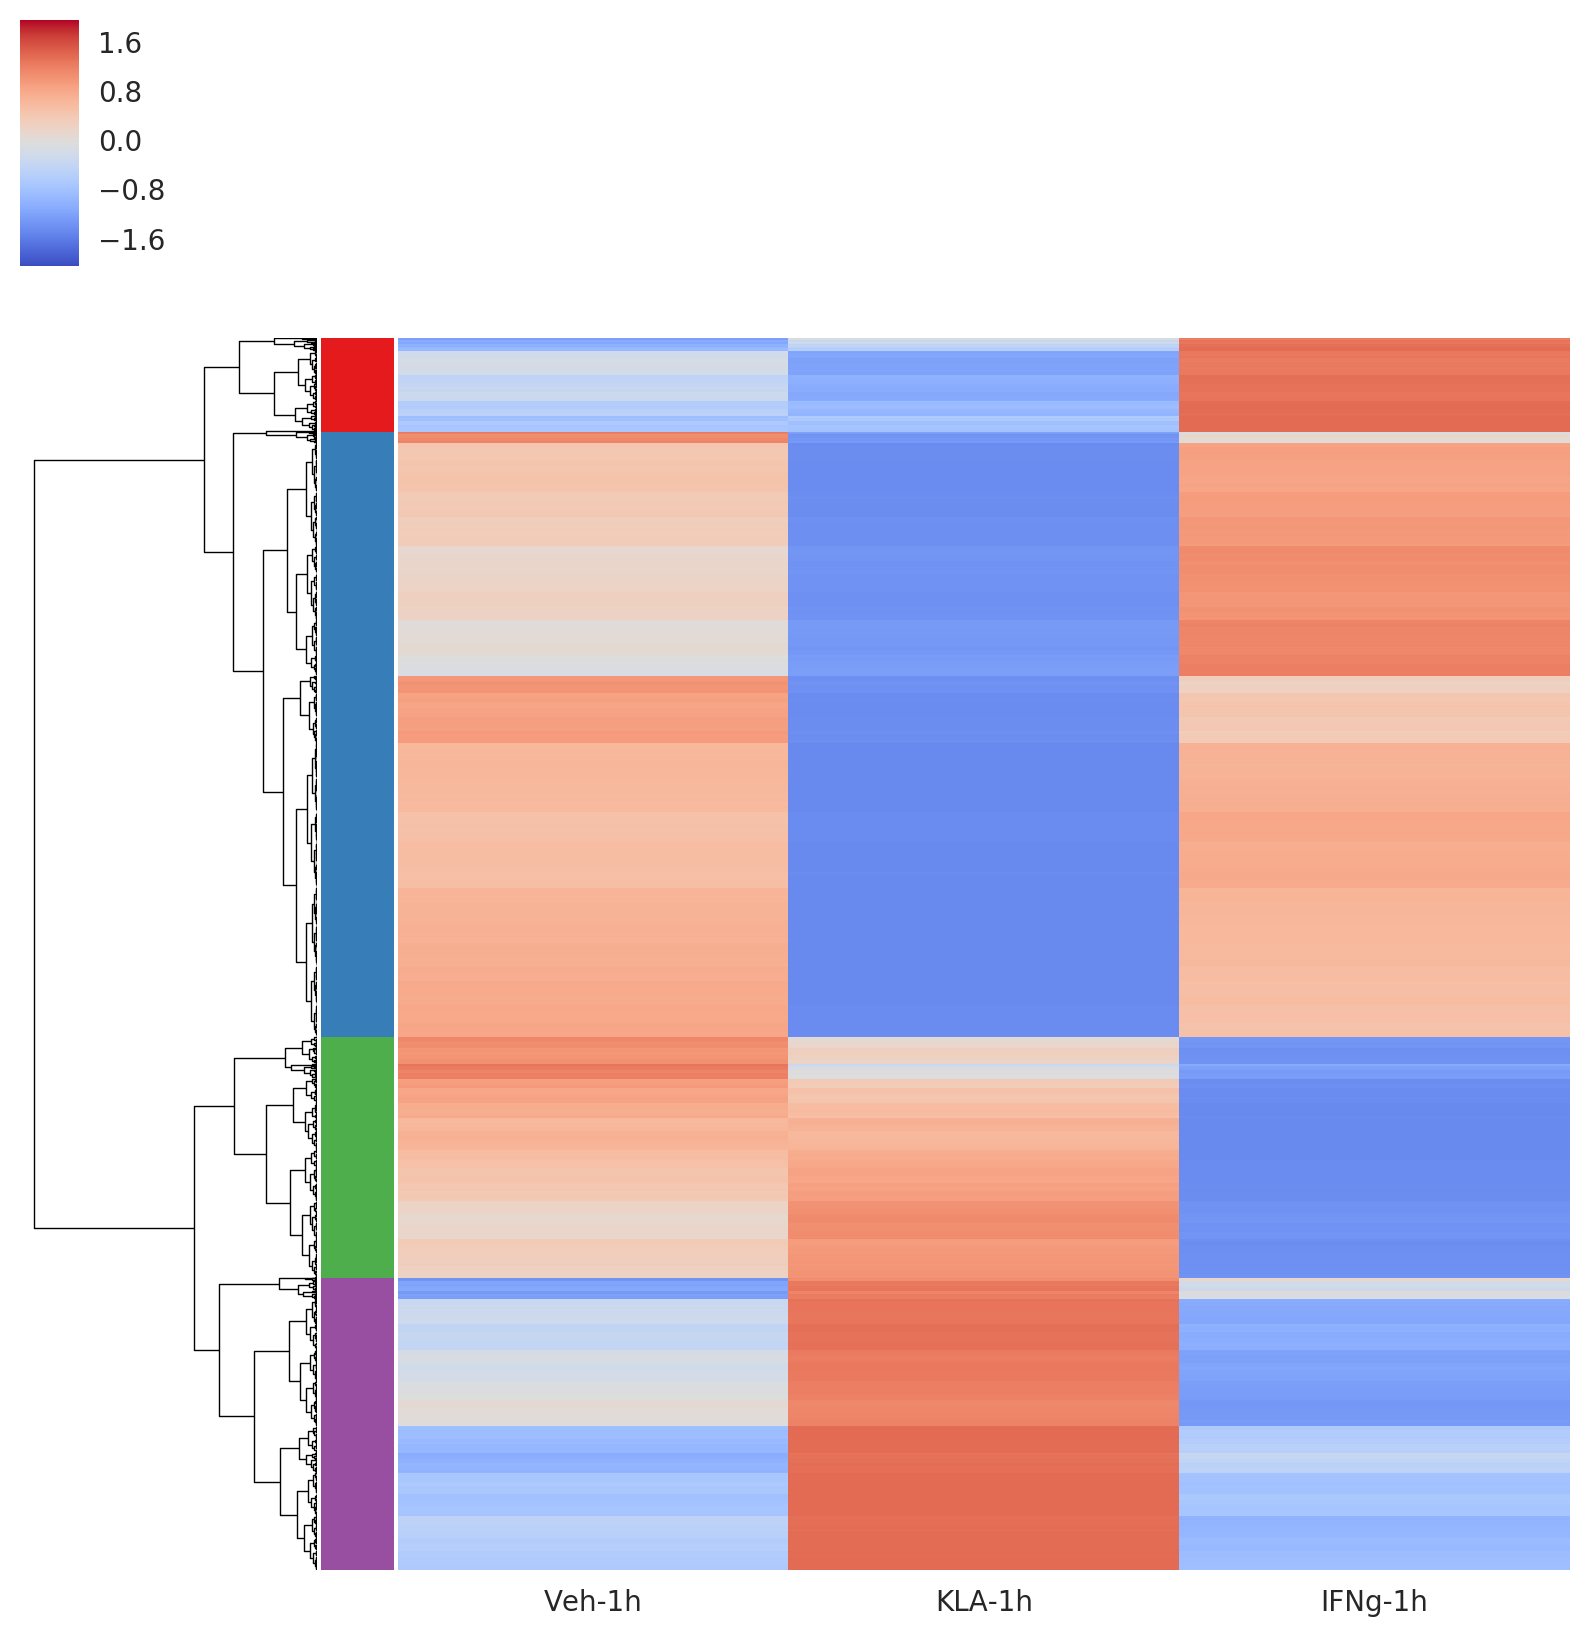

In [167]:
numRowClusters = 4
colorDict = dict(zip(range(numRowClusters),sns.color_palette("Set1")))

data = rpkm_mean_frame[(rpkm_mean_frame['Gene'].isin(diff_expressed_genes)) &
                (rpkm_mean_frame.ix[:,3:].max(axis=1) >= 4)].ix[:,2:]
# data = rpkm_mean_frame[(rpkm_mean_frame['Gene'].isin(diff_expressed_genes)) &
#                 (rpkm_mean_frame.ix[:,3:].max(axis=1) >= 4)].ix[:,['KLA-1h', 'IFNg-1h']]
zscores = np.log2(data+1).apply(scipy.stats.zscore, axis=1)
cg=sns.clustermap(zscores,
               yticklabels=False,
               col_cluster=False,
               row_cluster=True,
               vmin=-2,
               vmax=2,
               cmap='coolwarm'
              )
plt.close()
row_linkage = cg.dendrogram_row.linkage

row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")

row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(zscores.index))]
sns.clustermap(zscores, 
                row_linkage = row_linkage,
                row_colors = row_colors,
                yticklabels = False,
                col_cluster=False,
                vmin=-2,
                vmax=2,
                cmap='coolwarm'
)

print(data.shape)

## Identifying Signal Specific Syntax

In [201]:
gene_cluster_dict = dict(zip(zscores.index.values, row_flatCluster))
cluster_genes_dict = {x:[] for x in range(1,numRowClusters+1)}
for gene in gene_cluster_dict:
    cluster = gene_cluster_dict[gene] 
    cluster_genes_dict[cluster].append(gene)

In [202]:
id_sequence_array_dict = dict(zip(id_list, sequence_array_list))

In [ ]:
id_motif_sequence_dict = {}
for seq_index in range(len(sequence_array_list)):
    
    msl = calc_motif_sequence(seq_index,
                        sequence_array_list, 
                        motif_score_dict, 
                        motif_score_rc_dict, 
                        motif_size_dict,
                        threshold = 0,
                        symmetric_motifs = symmetric_motifs,
                       )
    seq_id = id_list[seq_index]
    id_motif_sequence_dict[seq_id] = msl
    if seq_index % 100 == 0:
        print(seq_index)

In [ ]:
pickle.dump(id_motif_sequence_dict, open('./id_motif_sequence_dict.pickle', 'wb'))

In [180]:
id_motif_sequence_dict = pickle.load(open('./id_motif_sequence_dict.pickle', 'rb'))

In [203]:
cluster_id_dict = {}
for cluster in cluster_genes_dict:
    cluster_genes = cluster_genes_dict[cluster]
#     cluster_seq_ids = [gene_id_dict[g] for g in cluster_genes]
    cluster_seq_ids = []
    print(cluster)
    print(len(cluster_genes), len(set(cluster_genes)))
    for g in cluster_genes:
        if g in gene_id_dict:
            cluster_seq_ids.append(gene_id_dict[g])
    cluster_id_dict[cluster] = cluster_seq_ids
    print(len(cluster_seq_ids), len(set(cluster_seq_ids)))


1
237 237
177 177
2
1539 1539
1099 1099
3
611 611
487 487
4
743 743
505 505


### Motif K-mers

In [282]:
k = 3
frequency_list = []
cluster_list = []
kmer_list = []

for key in cluster_id_dict:
    cluster_ids = cluster_id_dict[key]
    motif_sequence_list = [id_motif_sequence_dict[x] for x in cluster_ids ]
    kmer_count_dict = {}
    for msl in motif_sequence_list:
        for i in range(0, len(msl) - k + 1):
            kmer = msl[i:i+k]
            kmer_token = ' * '.join([m['name'] + ' ' + m['orientation'] for m in kmer])
            if kmer_token in kmer_count_dict:
                kmer_count_dict[kmer_token] +=1
            else:
                kmer_count_dict[kmer_token] = 1
    kmer_count_list = [(x,kmer_count_dict[x]) for x in kmer_count_dict]
    
    num_seqs = len(motif_sequence_list)
    frequencies = [x[1]/num_seqs for x in kmer_count_list]
    names = [x[0] for x in kmer_count_list]
    
    kmer_list = kmer_list + names
    cluster_list = cluster_list + [key] * len(frequencies)
    frequency_list = frequency_list + frequencies
            

In [283]:
frame = pd.DataFrame({'K-mer':kmer_list,
                      'Cluster':cluster_list,
                      'Frequency':frequency_list})

In [284]:
frame.sort('Frequency', ascending=False, inplace = True)
num_kmers_to_show = 50
kmers_to_show = set()
ordered_kmers = frame['K-mer'].values
counter = 0
while len(kmers_to_show) < num_kmers_to_show and counter < len(ordered_kmers):
    candidate = ordered_kmers[counter]
#     if 'ap-1' in candidate and 'cebp' in candidate:
    kmers_to_show.add(ordered_kmers[counter])
    counter +=1

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


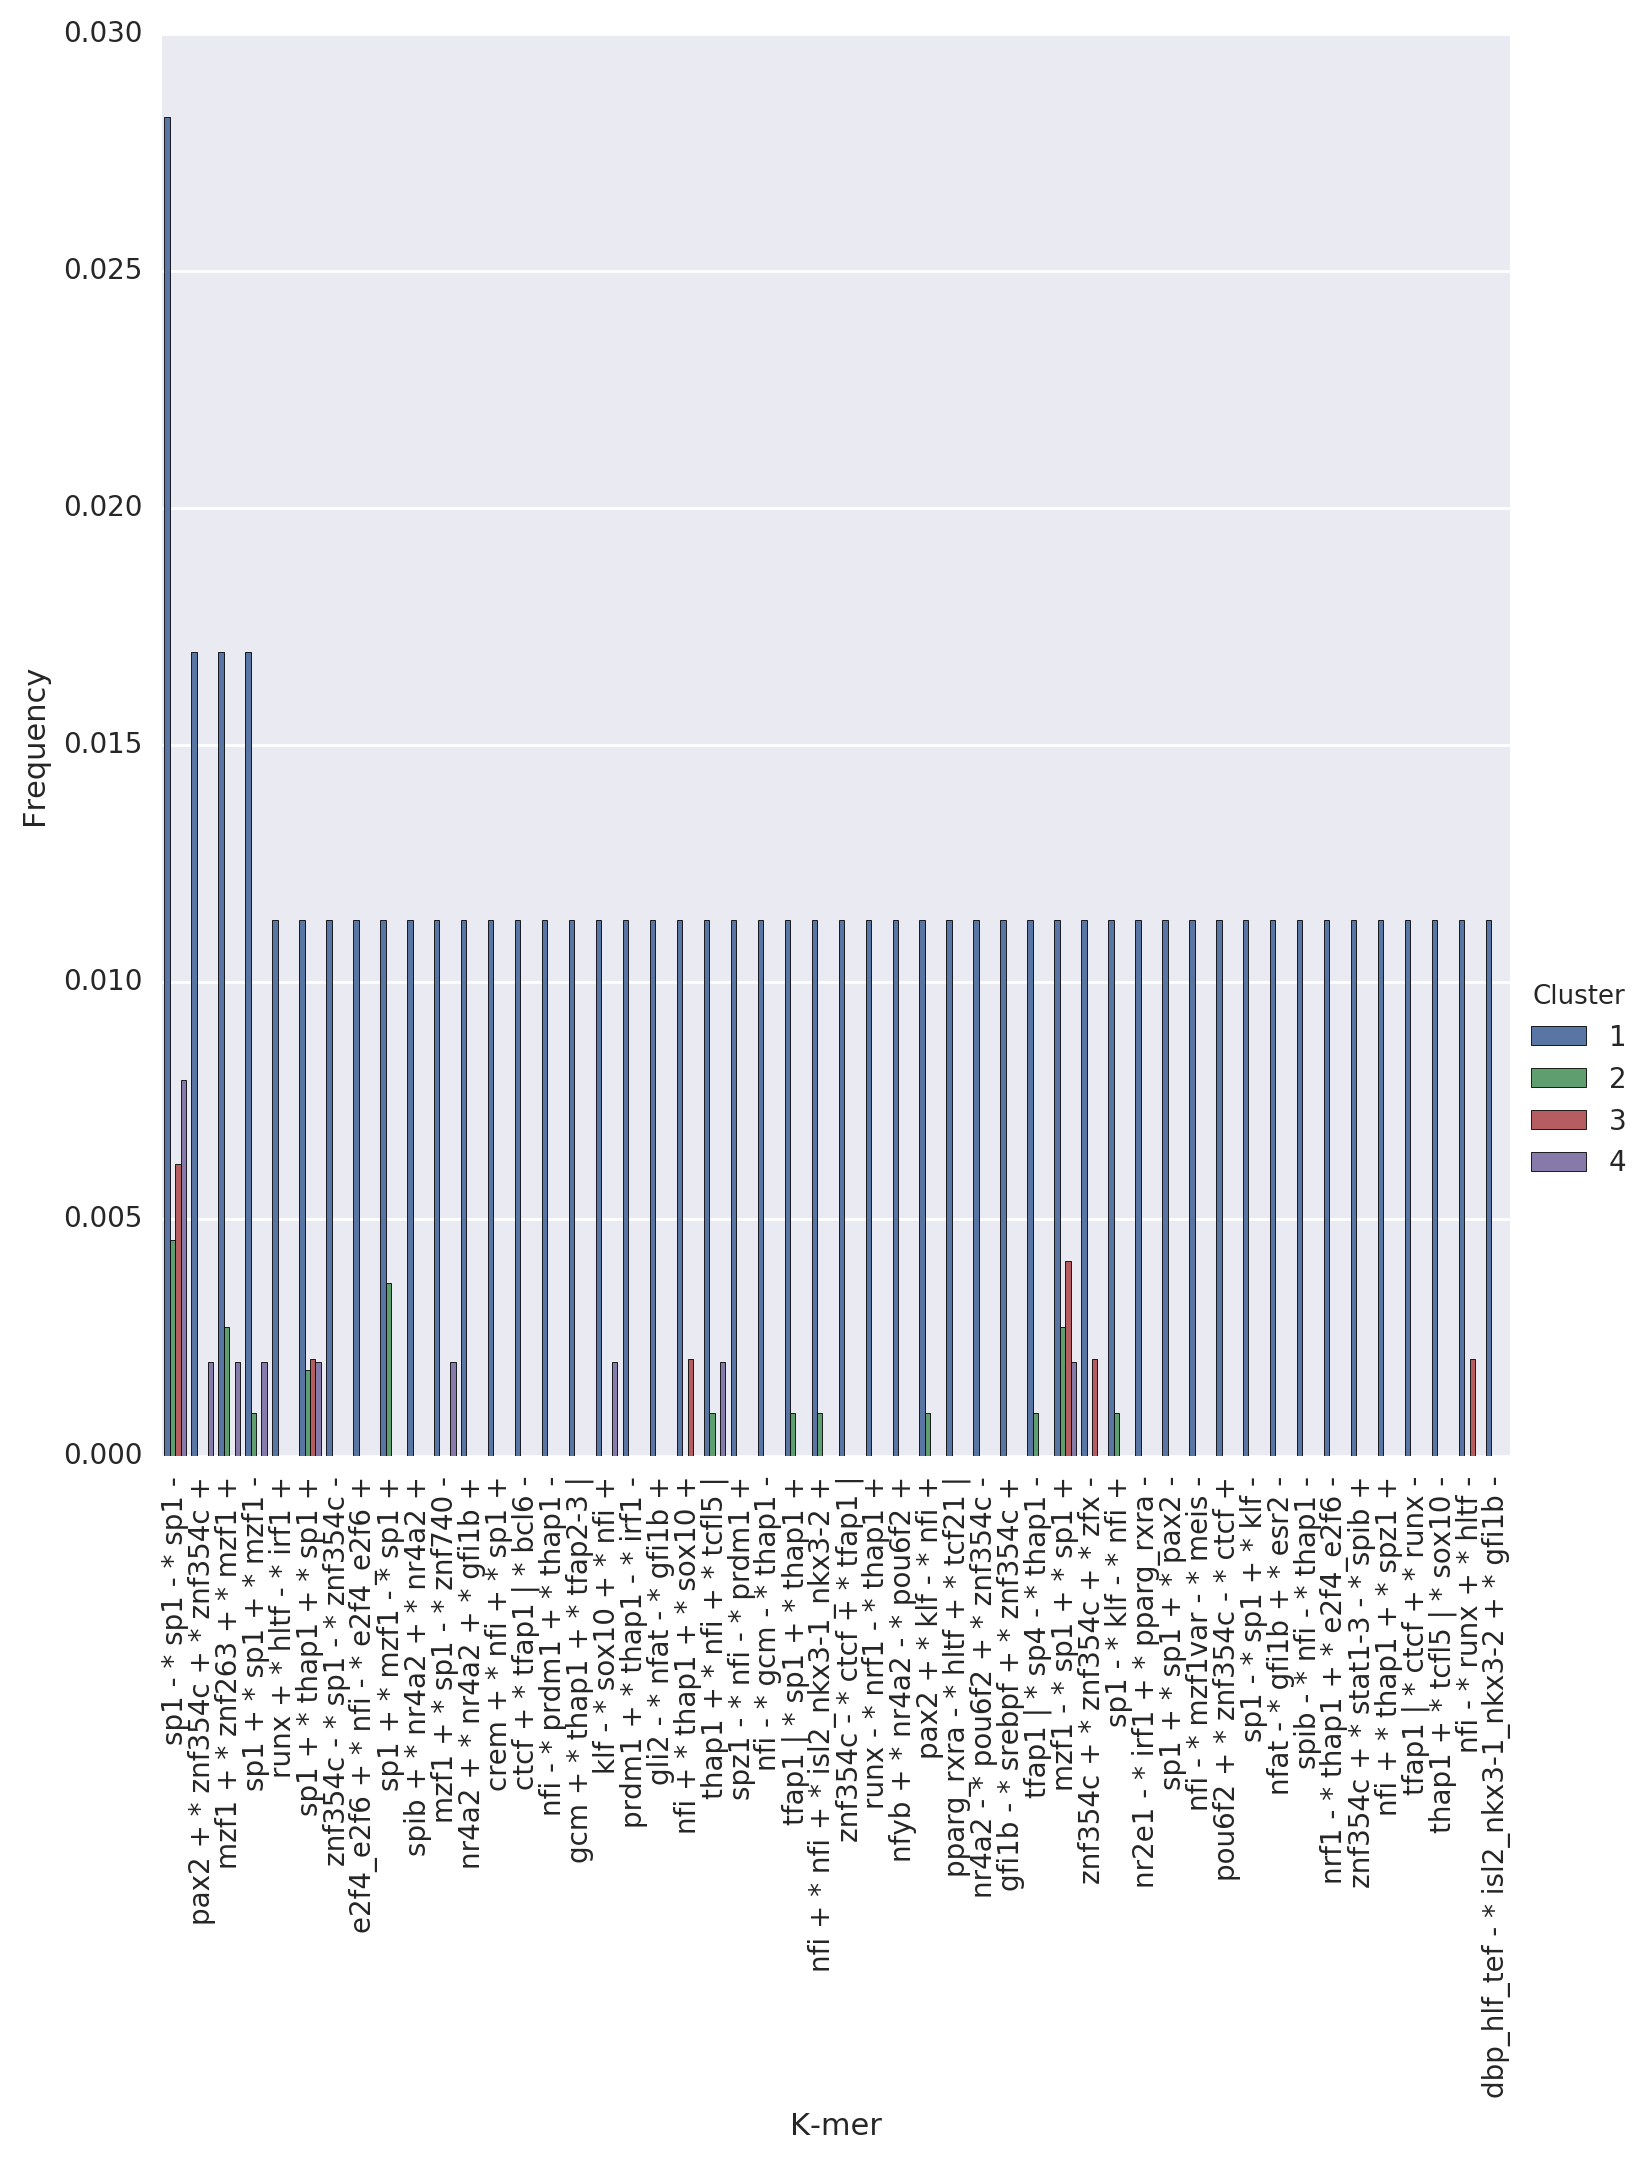

In [285]:
sns.factorplot(data = frame[frame['K-mer'].isin(kmers_to_show)],
               x='K-mer',
               y = 'Frequency',
               hue = 'Cluster',
               kind='bar',
               hue_order=[1,2,3,4],
               size=8)
plt.xticks(rotation = 90);

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


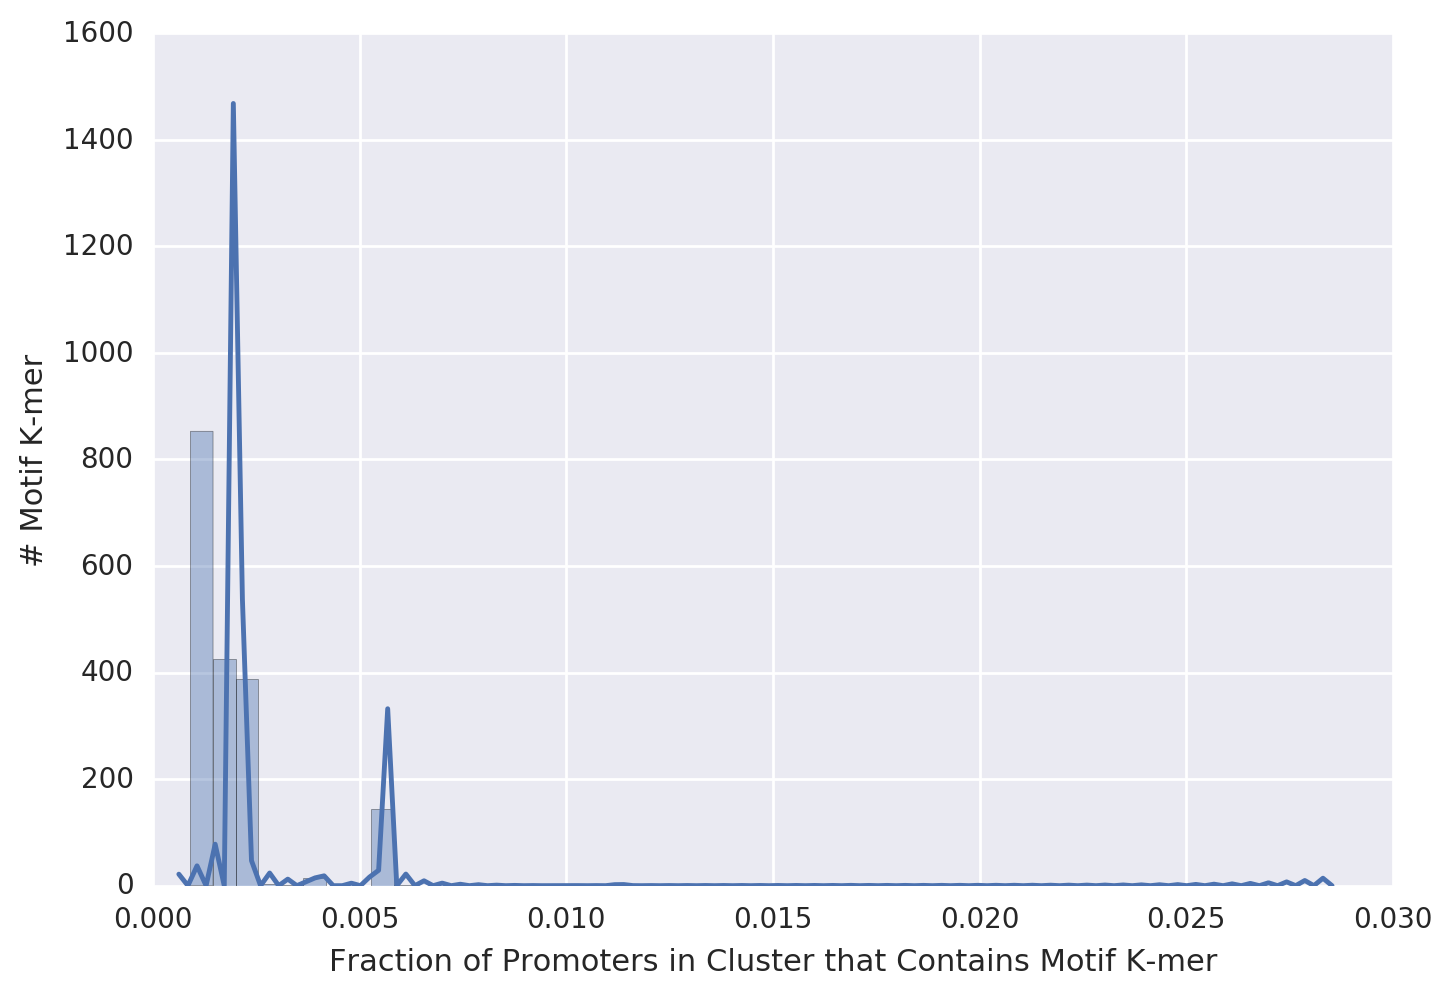

In [286]:
sns.distplot(frame['Frequency'])
plt.xlabel('Fraction of Promoters in Cluster that Contains Motif K-mer')
plt.ylabel('# Motif K-mer')

## Motif skip-mers

In [299]:
cluster_name_dict = {1:'IFNg Specific',2:'KLA Down',3:'IFNg Down',4:'KLA Specific'}

In [289]:
k = 3
frequency_list = []
cluster_list = []
kmer_list = []
for key in cluster_id_dict:
    print('cluster', key)
    cluster_ids = cluster_id_dict[key]
    motif_sequence_list = [id_motif_sequence_dict[x] for x in cluster_ids ]
    kmer_count_dict = {}
    counter = 0
    for msl in motif_sequence_list:
        for x in range(0,len(msl) - 2):
            for y in range(x+1, len(msl) - 1):
                for z in range(y+1, len(msl)):
                    kmer = [msl[x], msl[y], msl[z]]
                    kmer_token = ' * '.join([m['name'] + ' ' + m['orientation'] for m in kmer])
                    if kmer_token in kmer_count_dict:
                        kmer_count_dict[kmer_token] +=1
                    else:
                        kmer_count_dict[kmer_token] = 1
        counter+=1
        if counter %100 ==0:
            print(counter)
    kmer_count_list = [(x,kmer_count_dict[x]) for x in kmer_count_dict]
    
    num_seqs = len(motif_sequence_list)
    frequencies = [x[1]/num_seqs for x in kmer_count_list]
    names = [x[0] for x in kmer_count_list]
    
    kmer_list = kmer_list + names
    cluster_list = cluster_list + [key] * len(frequencies)
    frequency_list = frequency_list + frequencies
cluster_name_list = [cluster_name_dict[x] for x in cluster_list]

            

cluster 1
100
cluster 2
100
200
300
400
500
600
700
800
900
1000
cluster 3
100
200
300
400
cluster 4
100
200
300
400
500


In [301]:
frame = pd.DataFrame({'K-mer':kmer_list,
                      'Cluster':cluster_list,
                      'Frequency':frequency_list,
                      'Cluster Name':cluster_name_list})

In [305]:
frame.sort('Frequency', ascending=False, inplace = True)
num_kmers_to_show = 50
kmers_to_show = set()
ordered_kmers = frame['K-mer'].values
counter = 0
while len(kmers_to_show) < num_kmers_to_show and counter < len(ordered_kmers):
    candidate = ordered_kmers[counter]
    if not 'mzf1' in candidate and not 'nfi' in candidate:
        kmers_to_show.add(ordered_kmers[counter])
    counter +=1

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


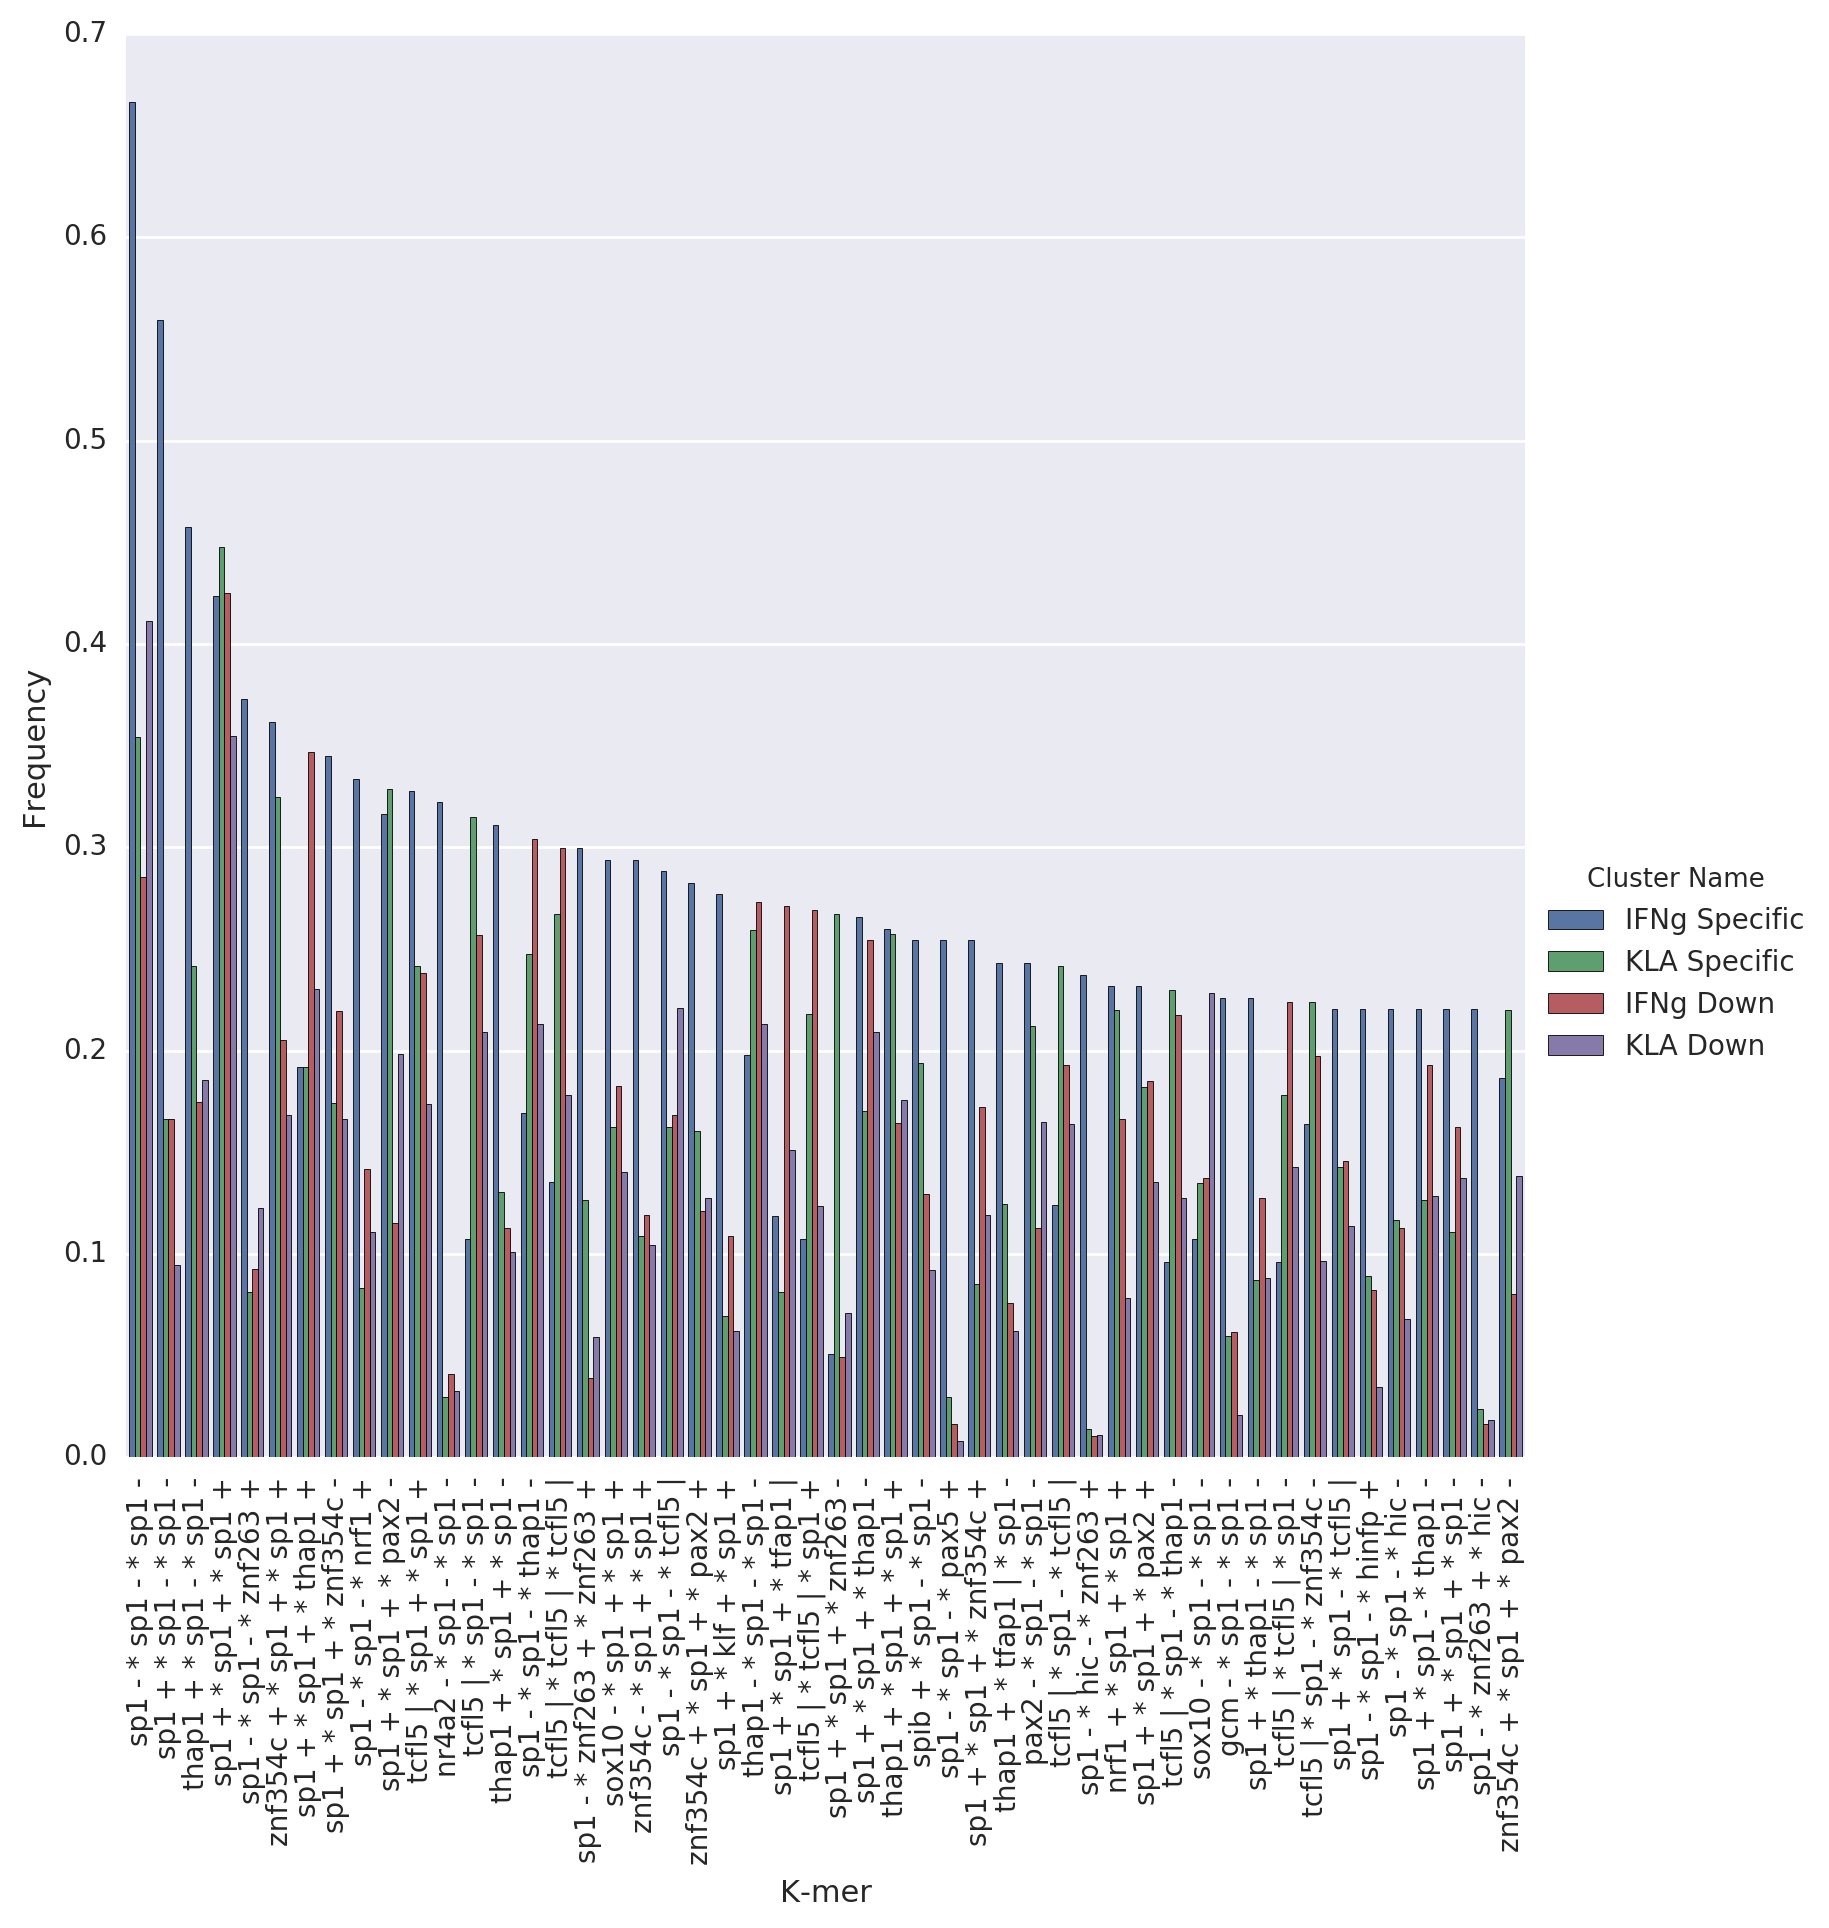

In [306]:
sns.factorplot(data = frame[frame['K-mer'].isin(kmers_to_show)],
               x='K-mer',
               y = 'Frequency',
               hue = 'Cluster Name',
               kind='bar',
#                hue_order=[1,2,3,4],
               size=8)
plt.xticks(rotation = 90);

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


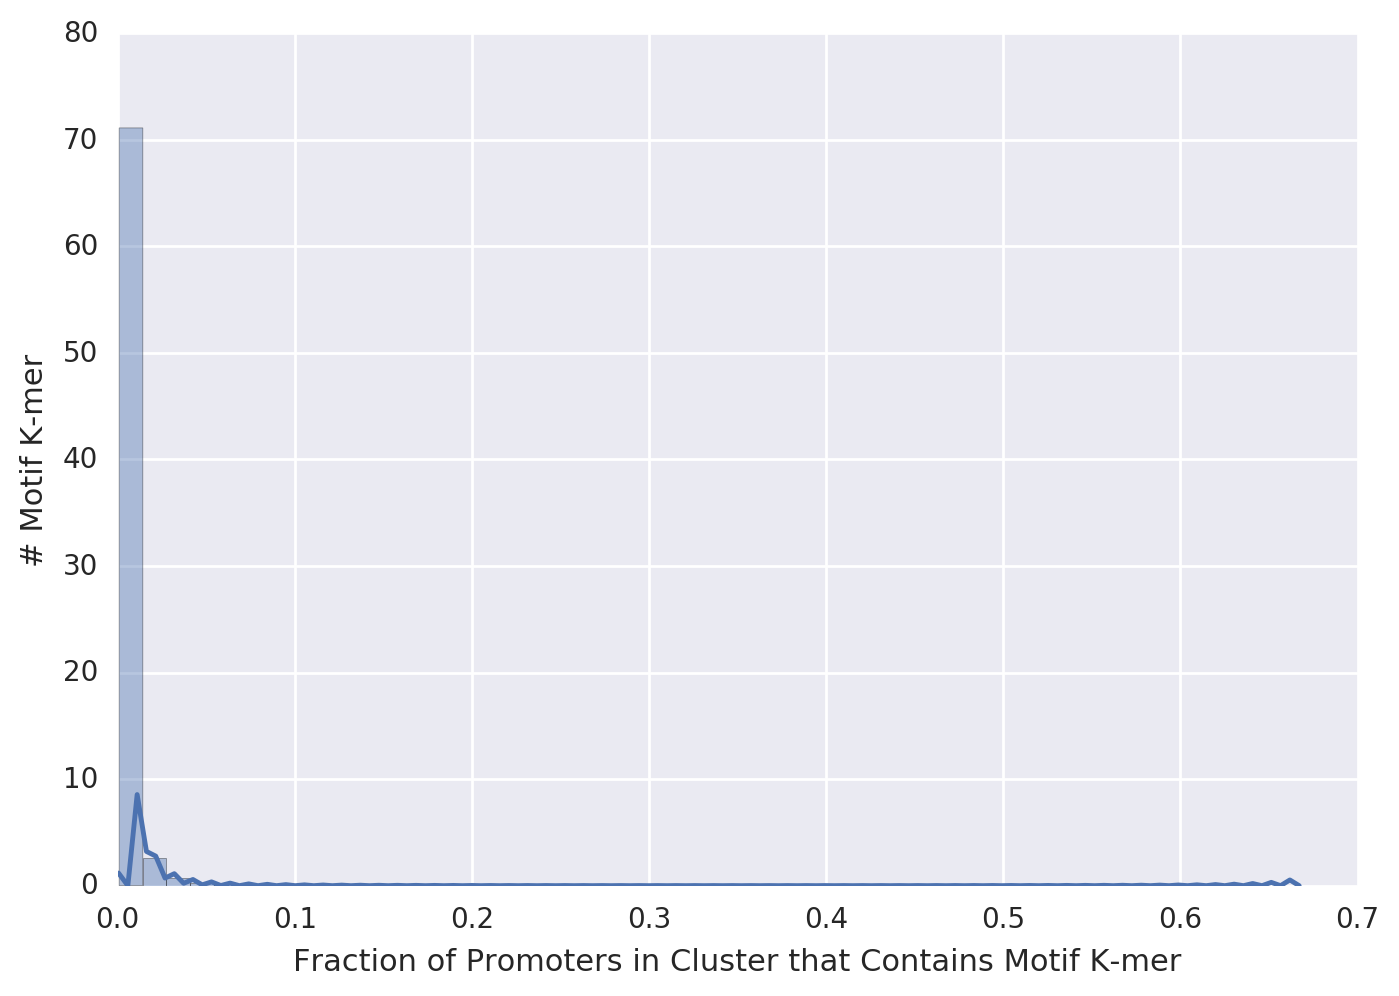

In [293]:
sns.distplot(frame['Frequency'])
plt.xlabel('Fraction of Promoters in Cluster that Contains Motif K-mer')
plt.ylabel('# Motif K-mer')

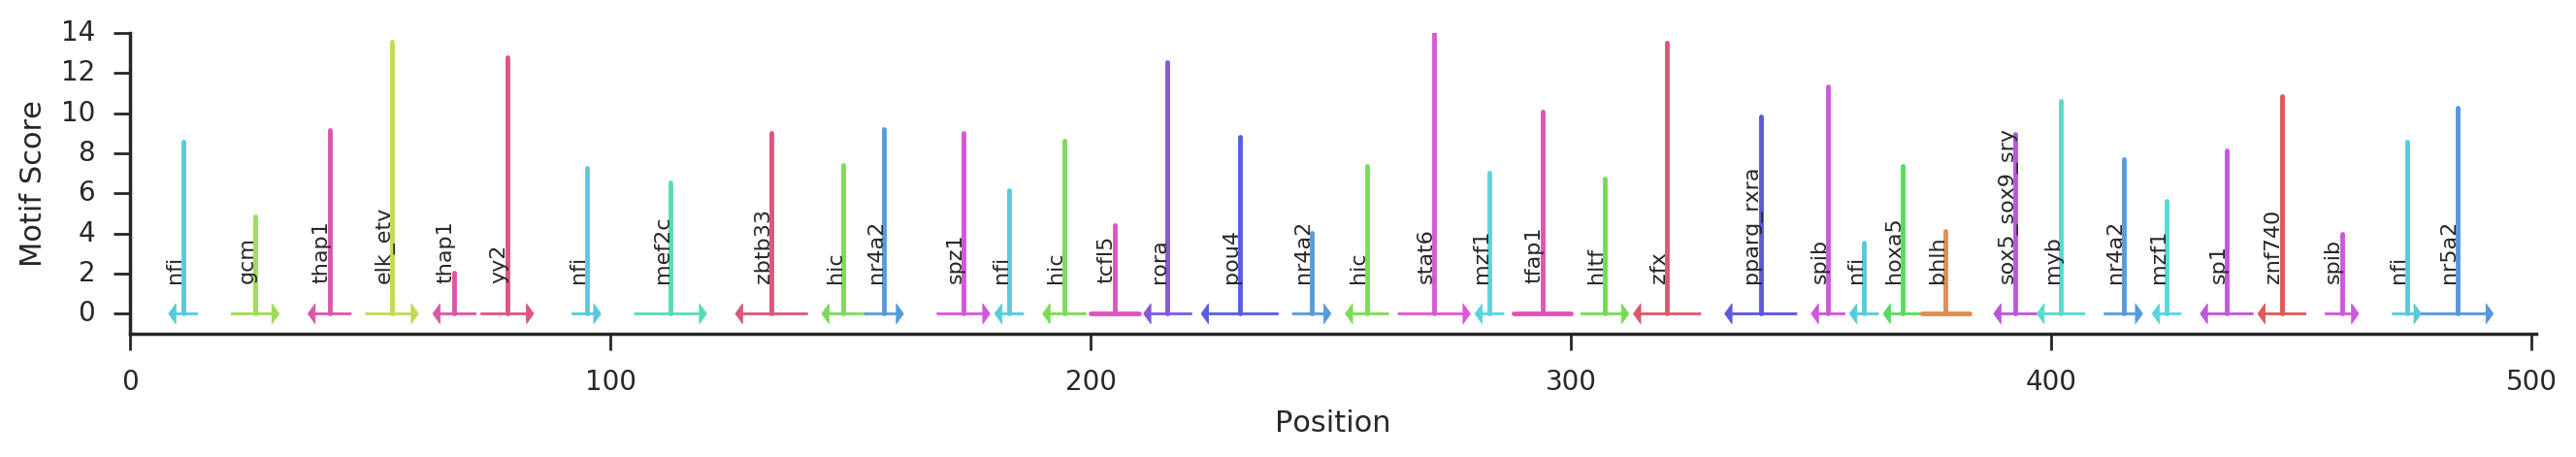

In [308]:
_=plot_motif_sequence(100,
                        sequence_array_list, 
                        motif_score_dict, 
                        motif_score_rc_dict, 
                        motif_size_dict,
                        threshold = 0,
                        color_dict = None,
                        symmetric_motifs = symmetric_motifs,
                        algorithm_plot = False,
                       )